In [6]:
CocoGenerator.preprocess_image??

In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


import keras
import keras.preprocessing.image
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf


from PIL import Image
from keras_retinanet.utils.image import preprocess_image # <-- this is the CocoGenerator.preprocess_image() method
from keras_retinanet.utils.image import resize_image # <-- this is CocoGenerator.resize_image()

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())


from keras_retinanet.models.resnet import custom_objects


model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# print(model.summary())

/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_10" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_10" during training.
  sample_weight_mode=sample_weight_mode)


In [18]:
# create image data generator object
# val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# createa a generator for testing data
# val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)
# index = 0

# image_generator = keras.preprocessing.image.ImageDataGenerator()

def detect_one(image=None, index=0, threshold=0.5):
    # load image if none given:
#     if type(image) == type(None):
#         image = val_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
#     image = val_generator.preprocess_image(image)
#     image, scale = val_generator.resize_image(image)
    
#     annotations = val_generator.load_annotations(index)
#     index += 1

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    count = 0
    max_score = -1

    from collections import OrderedDict

#     dets = []

#     max_score2 = -1

    caption = ""

    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        max_score = max(max_score, score)
        if score < threshold:
            continue
        b = detections[0, idx, :4].astype(int)

        assert len(b) == 4

        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
#         caption = f'{val_generator.label_to_name(label)} {score:.3f}'
        caption = f'Pilot {score:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)

    print(caption)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()


def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5):
    if folder == "":
        print("No folder specified")
        return

    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    detect_one(image, threshold=threshold)

Image path: data/train/004152-004401/004310.jpg
processing time:  9.52820611000061
Pilot 0.672


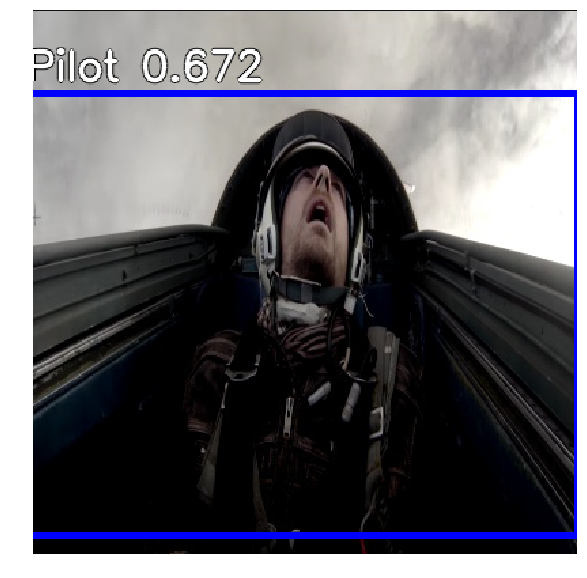

In [17]:
trainpath = 'data/train/'
folders = os.listdir(trainpath)

detect_pilot(folder = np.random.choice(folders))